In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import glob

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

from sklearn.metrics import jaccard_score


tqdm.pandas()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
train_df = pd.read_csv('data/train.csv')
print("Training Data:" , train_df.shape)

test_df = pd.read_csv('data/test.csv')
print("Test Data:" , test_df.shape)

Training Data: (1200000, 21)
Test Data: (800000, 20)


In [3]:


#Drop ID
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

In [4]:
# #Age nan values
# train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())
# test_df['Age'] = test_df['Age'].fillna(test_df['Age'].mean())

# #Annual Income nan values
# train_df['Annual Income'] = train_df['Annual Income'].fillna(train_df['Annual Income'].mean())
# test_df['Annual Income'] = test_df['Annual Income'].fillna(test_df['Annual Income'].mean())

# #marital status nan values
# train_df['Marital Status'] = train_df['Marital Status'].fillna('other')
# test_df['Marital Status'] = test_df['Marital Status'].fillna('other')

# #Number of Dependents nan values
# train_df['Number of Dependents'] = train_df['Number of Dependents'].fillna(0)
# test_df['Number of Dependents'] = test_df['Number of Dependents'].fillna(0)

# #Occupation nan values
# train_df['Occupation'] = train_df['Occupation'].fillna('other')
# test_df['Occupation'] = test_df['Occupation'].fillna('other')

# #Health Score nan values
# train_df['Health Score'] = train_df['Health Score'].fillna(train_df['Health Score'].mode()[0])
# test_df['Health Score'] = test_df['Health Score'].fillna(test_df['Health Score'].mode()[0])

# #Previous Claims nan values
# train_df['Previous Claims'] = train_df['Previous Claims'].fillna(train_df['Previous Claims'].mode()[0])
# test_df['Previous Claims'] = test_df['Previous Claims'].fillna(test_df['Previous Claims'].mode()[0])

# #Vehicle Age nan values
# train_df['Vehicle Age'] = train_df['Vehicle Age'].fillna(train_df['Vehicle Age'].mode()[0])
# test_df['Vehicle Age'] = test_df['Vehicle Age'].fillna(test_df['Vehicle Age'].mode()[0])

# #Credit Score nan values
# train_df['Credit Score'] = train_df['Credit Score'].fillna(train_df['Credit Score'].mean())
# test_df['Credit Score'] = test_df['Credit Score'].fillna(test_df['Credit Score'].mean())

# #Insurance Duration nan values
# train_df['Insurance Duration'] = train_df['Insurance Duration'].fillna(train_df['Insurance Duration'].mode()[0])
# test_df['Insurance Duration'] = test_df['Insurance Duration'].fillna(test_df['Insurance Duration'].mode()[0])

# #Customer Feedback nan values
# train_df['Customer Feedback'] = train_df['Customer Feedback'].fillna('other')
# test_df['Customer Feedback'] = test_df['Customer Feedback'].fillna('other')

# # Policy Start Date  nan values
# train_df['Policy Start Date'] = train_df['Policy Start Date'].fillna(train_df['Policy Start Date'].mode()[0])
# test_df['Policy Start Date'] = test_df['Policy Start Date'].fillna(test_df['Policy Start Date'].mode()[0])

# train_df.head()
# test_df.head()

In [5]:

train_df['Policy Start Date'] = pd.to_datetime(train_df['Policy Start Date'])
test_df['Policy Start Date'] = pd.to_datetime(test_df['Policy Start Date'])

train_df['Policy Year'] = train_df['Policy Start Date'].dt.year
test_df['Policy Year'] = test_df['Policy Start Date'].dt.year

#Policy Start Date drop 
train_df.drop('Policy Start Date', axis=1, inplace=True)
test_df.drop('Policy Start Date', axis=1, inplace=True)

In [6]:
# Kredi Skoru / Yaş Oranı 
train_df['Credit Score / Age'] = train_df['Credit Score'] / train_df['Age']
test_df['Credit Score / Age'] = test_df['Credit Score'] / test_df['Age']

# Sigorta Süresi * Sağlık Skoru
train_df['Insurance Duration * Health Score'] = train_df['Insurance Duration'] * train_df['Health Score']
test_df['Insurance Duration * Health Score'] = test_df['Insurance Duration'] * test_df['Health Score']


# income per dependent
train_df['Income per Dependent'] = train_df['Annual Income'] / (train_df['Number of Dependents'] + 1)
test_df['Income per Dependent'] = test_df['Annual Income'] / (test_df['Number of Dependents'] + 1)

# age times




In [7]:
# Credit Score / Age , Credit Score / Annual Income , Insurance Duration * Health Score min-max scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_df['Insurance Duration * Health Score'] = scaler.fit_transform(train_df['Insurance Duration * Health Score'].values.reshape(-1, 1))
test_df['Insurance Duration * Health Score'] = scaler.transform(test_df['Insurance Duration * Health Score'].values.reshape(-1, 1))


In [8]:
train_df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Policy Year,Credit Score / Age,Insurance Duration * Health Score,Income per Dependent
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,Poor,No,Weekly,House,2869.0,2023,19.578947,0.216046,5024.5
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,Average,Yes,Monthly,House,1483.0,2023,17.794872,0.056627,7919.5
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,Good,Yes,Weekly,House,567.0,2023,NaN,0.271628,6400.5
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,Poor,Yes,Daily,Apartment,765.0,2024,17.476190,0.017283,47285.0
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,Poor,Yes,Weekly,House,2022.0,2021,28.476190,0.154717,19825.5


# SCALER COLMS

In [9]:
#one hot encoding for date features
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
date_features = ['Policy Year' ]

train_encoded = encoder.fit_transform(train_df[date_features])
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(date_features))
train_df = pd.concat([train_df, train_encoded_df], axis=1)
train_df.drop(columns=date_features, inplace=True)

test_encoded = encoder.transform(test_df[date_features])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(date_features))
test_df = pd.concat([test_df, test_encoded_df], axis=1)
test_df.drop(columns=date_features, inplace=True)



In [10]:
#Age Min Max Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_df['Age'] = scaler.fit_transform(train_df['Age'].values.reshape(-1, 1))
test_df['Age'] = scaler.transform(test_df['Age'].values.reshape(-1, 1))

In [11]:
#Annual Income log scaling
scaler = MinMaxScaler()
train_df['Annual Income'] = np.log1p(train_df['Annual Income'])
test_df['Annual Income'] = np.log1p(test_df['Annual Income'])

In [12]:
# income per dependent min max scaling
scaler = MinMaxScaler()
train_df['Income per Dependent'] = scaler.fit_transform(train_df['Income per Dependent'].values.reshape(-1, 1))
test_df['Income per Dependent'] = scaler.transform(test_df['Income per Dependent'].values.reshape(-1, 1))

In [13]:
#Number of Dependents Min Max Scaling
scaler = MinMaxScaler()
train_df['Number of Dependents'] = scaler.fit_transform(train_df['Number of Dependents'].values.reshape(-1, 1))
test_df['Number of Dependents'] = scaler.transform(test_df['Number of Dependents'].values.reshape(-1, 1))

In [14]:
#Health Score Min Max Scaling
scaler = MinMaxScaler()
train_df['Health Score'] = scaler.fit_transform(train_df['Health Score'].values.reshape(-1, 1))
test_df['Health Score'] = scaler.transform(test_df['Health Score'].values.reshape(-1, 1))

In [15]:
#Vehicle Age Min Max Scaling
scaler = MinMaxScaler()
train_df['Vehicle Age'] = scaler.fit_transform(train_df['Vehicle Age'].values.reshape(-1, 1))
test_df['Vehicle Age'] = scaler.transform(test_df['Vehicle Age'].values.reshape(-1, 1))

In [16]:
#Previous Claims Min Max Scaling
scaler = MinMaxScaler()
train_df['Previous Claims'] = scaler.fit_transform(train_df['Previous Claims'].values.reshape(-1, 1))
test_df['Previous Claims'] = scaler.transform(test_df['Previous Claims'].values.reshape(-1, 1))

In [17]:
#Credit Score Min Max Scaling
scaler = MinMaxScaler()
train_df['Credit Score'] = scaler.fit_transform(train_df['Credit Score'].values.reshape(-1, 1))
test_df['Credit Score'] = scaler.transform(test_df['Credit Score'].values.reshape(-1, 1))

In [18]:
#Insurance Duration Min Max Scaling
scaler = MinMaxScaler()
train_df['Insurance Duration'] = scaler.fit_transform(train_df['Insurance Duration'].values.reshape(-1, 1))
test_df['Insurance Duration'] = scaler.transform(test_df['Insurance Duration'].values.reshape(-1, 1))

In [19]:
#Smoking Status One Hot Encoding
train_df = pd.get_dummies(train_df, columns=['Smoking Status'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Smoking Status'], drop_first=True)

In [20]:
#Gender ONE HOT ENCODING
train_df = pd.get_dummies(train_df, columns=['Gender'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Gender'], drop_first=True)

In [21]:
#Martial Status ONE HOT ENCODING
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
train_encoded = encoder.fit_transform(train_df[['Marital Status']])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Marital Status']))
train_df = pd.concat([train_df, train_encoded_df], axis=1)
train_df.drop(columns=['Marital Status'], inplace=True)

test_encoded = encoder.transform(test_df[['Marital Status']])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Marital Status']))
test_df = pd.concat([test_df, test_encoded_df], axis=1)
test_df.drop(columns=['Marital Status'], inplace=True)

In [22]:
#Occupation ONE HOT ENCODING
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
train_encoded = encoder.fit_transform(train_df[['Occupation']])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Occupation']))
train_df = pd.concat([train_df, train_encoded_df], axis=1)
train_df.drop(columns=['Occupation'], inplace=True)

test_encoded = encoder.transform(test_df[['Occupation']])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Occupation']))
test_df = pd.concat([test_df, test_encoded_df], axis=1)
test_df.drop(columns=['Occupation'], inplace=True)

In [23]:
#Education Level ONE HOT ENCODING
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
train_encoded = encoder.fit_transform(train_df[['Education Level']])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Education Level']))
train_df = pd.concat([train_df, train_encoded_df], axis=1)
train_df.drop(columns=['Education Level'], inplace=True)

test_encoded = encoder.transform(test_df[['Education Level']])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Education Level']))
test_df = pd.concat([test_df, test_encoded_df], axis=1)
test_df.drop(columns=['Education Level'], inplace=True)

In [24]:
#Location ONE HOT ENCODING
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
train_encoded = encoder.fit_transform(train_df[['Location']])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Location']))
train_df = pd.concat([train_df, train_encoded_df], axis=1)
train_df.drop(columns=['Location'], inplace=True)

test_encoded = encoder.transform(test_df[['Location']])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Location']))
test_df = pd.concat([test_df, test_encoded_df], axis=1)
test_df.drop(columns=['Location'], inplace=True)

In [25]:
#Policy Type ONE HOT ENCODING
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
train_encoded = encoder.fit_transform(train_df[['Policy Type']])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Policy Type']))
train_df = pd.concat([train_df, train_encoded_df], axis=1)
train_df.drop(columns=['Policy Type'], inplace=True)

test_encoded = encoder.transform(test_df[['Policy Type']])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Policy Type']))
test_df = pd.concat([test_df, test_encoded_df], axis=1)
test_df.drop(columns=['Policy Type'], inplace=True)

In [26]:
#Customer Feedback ONE HOT ENCODING
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
train_encoded = encoder.fit_transform(train_df[['Customer Feedback']])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Customer Feedback']))
train_df = pd.concat([train_df, train_encoded_df], axis=1)
train_df.drop(columns=['Customer Feedback'], inplace=True)

test_encoded = encoder.transform(test_df[['Customer Feedback']])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Customer Feedback']))
test_df = pd.concat([test_df, test_encoded_df], axis=1)
test_df.drop(columns=['Customer Feedback'], inplace=True)

In [27]:
#Exercise Frequency ONE HOT ENCODING
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
train_encoded = encoder.fit_transform(train_df[['Exercise Frequency']])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Exercise Frequency']))
train_df = pd.concat([train_df, train_encoded_df], axis=1)
train_df.drop(columns=['Exercise Frequency'], inplace=True)

test_encoded = encoder.transform(test_df[['Exercise Frequency']])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Exercise Frequency']))
test_df = pd.concat([test_df, test_encoded_df], axis=1)
test_df.drop(columns=['Exercise Frequency'], inplace=True)

In [28]:
#Property Type ONE HOT ENCODING
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
train_encoded = encoder.fit_transform(train_df[['Property Type']])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Property Type']))
train_df = pd.concat([train_df, train_encoded_df], axis=1)
train_df.drop(columns=['Property Type'], inplace=True)

test_encoded = encoder.transform(test_df[['Property Type']])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Property Type']))
test_df = pd.concat([test_df, test_encoded_df], axis=1)
test_df.drop(columns=['Property Type'], inplace=True)


# TRAINING

In [29]:
# #predict credit score nan values with xgboost classifier and fill nan values without using Premium Amount colm
# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# train_df['Credit Score'] = train_df['Credit Score'].fillna(-1)
# test_df['Credit Score'] = test_df['Credit Score'].fillna(-1)

# train = train_df[train_df['Credit Score'] != -1]
# test = train_df[train_df['Credit Score'] == -1]

# X = train.drop(columns=['Credit Score', 'Premium Amount'])
# y = pd.cut(train['Credit Score'], bins=10, labels=False)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = XGBClassifier()
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

# test = test.drop(columns=['Credit Score', 'Premium Amount'])
# test['Credit Score'] = model.predict(test)

# train_df.loc[train_df['Credit Score'] == -1, 'Credit Score'] = test['Credit Score']

# # now fill nan values in test_df

# test_df['Credit Score'] = test_df['Credit Score'].fillna(-1)
# test = test_df[test_df['Credit Score'] == -1]
# test = test.drop(columns=['Credit Score'])
# test['Credit Score'] = model.predict(test)

# test_df.loc[test_df['Credit Score'] == -1, 'Credit Score'] = test['Credit Score']

# #predict credit score nan values with xgboost classifier and fill nan values without using Premium Amount colm

In [30]:
#Credit Score Min Max Scaling
scaler = MinMaxScaler()
train_df['Credit Score'] = scaler.fit_transform(train_df['Credit Score'].values.reshape(-1, 1))
test_df['Credit Score'] = scaler.transform(test_df['Credit Score'].values.reshape(-1, 1))

In [31]:
# print(train_df['Age'].isnull().sum())
# print(train_df['Annual Income'].isnull().sum())
# print(train_df['Credit Score'].isnull().sum())


In [32]:
print(train_df.head ())

        Age  Annual Income  Number of Dependents  Health Score  Previous Claims  Vehicle Age  Credit Score  Insurance Duration  Premium Amount  Credit Score / Age  Insurance Duration * Health Score  Income per Dependent  Policy Year_2019  Policy Year_2020  Policy Year_2021  Policy Year_2022  Policy Year_2023  Policy Year_2024  Smoking Status_Yes  Gender_Male  Marital Status_Divorced  Marital Status_Married  Marital Status_Single  Marital Status_nan  Occupation_Employed  Occupation_Self-Employed  Occupation_Unemployed  Occupation_nan  Education Level_Bachelor's  Education Level_High School  Education Level_Master's  Education Level_PhD  Location_Rural  Location_Suburban  Location_Urban  Policy Type_Basic  Policy Type_Comprehensive  Policy Type_Premium  Customer Feedback_Average  Customer Feedback_Good  Customer Feedback_Poor  Customer Feedback_nan  Exercise Frequency_Daily  Exercise Frequency_Monthly  Exercise Frequency_Rarely  Exercise Frequency_Weekly  Property Type_Apartment  \
0  0.

In [33]:
y_data = train_df['Premium Amount']
X_data = train_df.drop('Premium Amount', axis=1) 


In [34]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 49 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   Age                                1181295 non-null  float64
 1   Annual Income                      1155051 non-null  float64
 2   Number of Dependents               1090328 non-null  float64
 3   Health Score                       1125924 non-null  float64
 4   Previous Claims                    835971 non-null   float64
 5   Vehicle Age                        1199994 non-null  float64
 6   Credit Score                       1062118 non-null  float64
 7   Insurance Duration                 1199999 non-null  float64
 8   Premium Amount                     1200000 non-null  float64
 9   Credit Score / Age                 1045562 non-null  float64
 10  Insurance Duration * Health Score  1125923 non-null  float64
 11  Income per Dependent    

In [35]:
x_data_test = test_df

In [36]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Modelleri tanımlama
models = {
    "LightGBM": lgb.LGBMRegressor(),
    
}

# Modelleri eğitme ve değerlendirme
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred)))
    print(f"{name} - MSE: {mse}, RMSLE: {rmsle}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1693
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 48
[LightGBM] [Info] Start training from score 1102.505529
LightGBM - MSE: 697656.1328546506, RMSLE: 1.1332831351292911


In [37]:
# y_pred_test = models['LightGBM'].predict(x_data_test)

# submission_df = pd.read_csv('sample_submission.csv')
# submission_df['Premium Amount'] = y_pred_test
# submission_df.to_csv('data/submission1.csv', index=False)

In [38]:
# charts
import matplotlib.pyplot as plt
import seaborn as sns





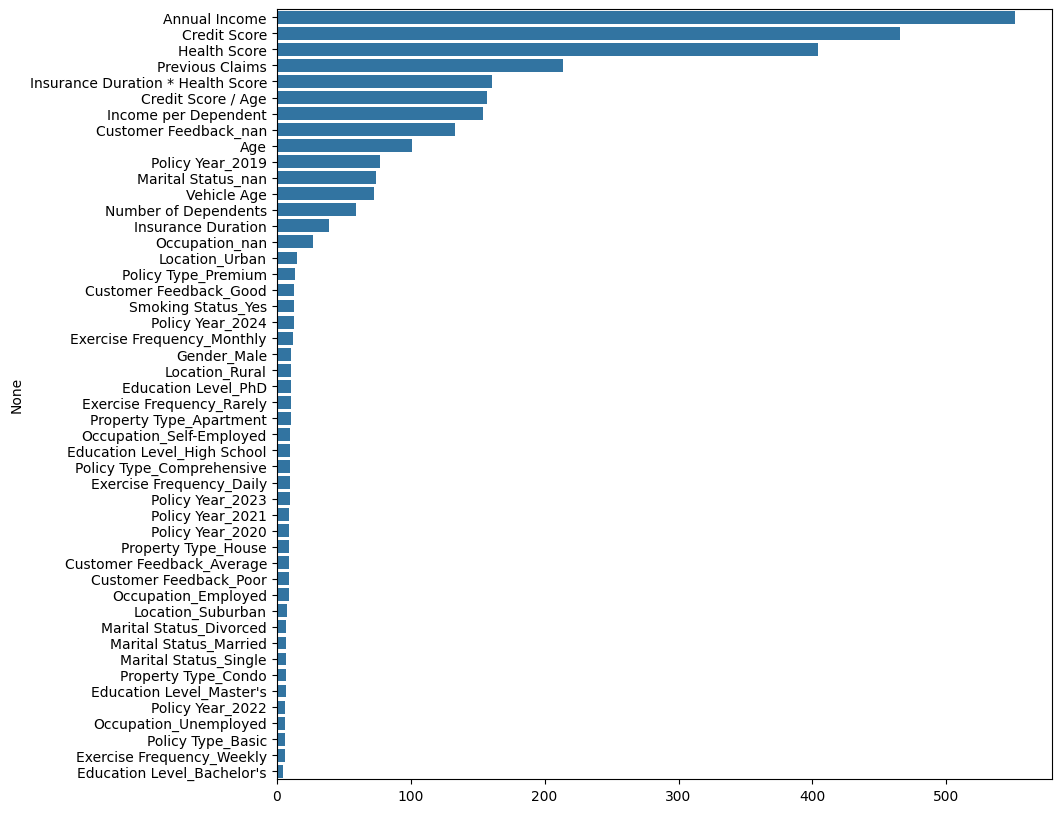

In [39]:
# Feature Importance'ı büyükten küçüğe doğru sıralayarak görselleştirme
plt.figure(figsize=(10, 10))
feature_importance = models['LightGBM'].feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
sns.barplot(x=feature_importance[sorted_idx], y=X_data.columns[sorted_idx])
plt.show()
